# Clasificación de grafos

En este notebook se muestra cómo se ha entrenado el clasificador de grafos.

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import networkx as nx

from src.aitor_utils import Graph_gen, get_blockade_configurations2, C_from_gr

# Funciones auxiliares

In [16]:
def obtener_espectro(seed, n_nodos=7, atoms_w=4, atoms_l=3):
    """
    Obtiene el espectro del grafo.
    
    Args:
        seed (int): Semilla para la generación.
        n_nodos (int): Número de átomos.
        atoms_w (int): Anchura de la malla.
        atoms_l (int): Longitud de la malla.
        
    Returns:
        tuple: Espectro de la función de coste.
    """
    scale = 5e-6  # Escala de la malla
    np.random.seed(seed)
    G, register = Graph_gen(n_nodos, atoms_w, atoms_l, scale)

    # Guardamos propiedades relevantes del grafo
    og_weights = np.array(list(nx.get_node_attributes(G, 'weight').values()))
    positions = np.array(list(nx.get_node_attributes(G, 'pos').values()))

    conf = get_blockade_configurations2(positions, 7.2e-6)
    espectro = pd.DataFrame(conf, columns=['bitstring'])
    espectro['energia'] = espectro['bitstring'].apply(lambda x: C_from_gr(x, og_weights, G.nodes()))
    
    return tuple(espectro.energia)

def calcular_bins(espectro, n_bins=4):
    """
    Calcula el número de instancias en cada bin de la región e_gap=(0, 0.2)

    Args:
        espectro (tuple): tupla con las energías del espectro de la función de coste.
        n_bins (int): Número de bins en la región e_gap=(0, 0.2).
    """
    # Definimos los límites de los bins
    bins = np.linspace(0, 0.2, n_bins + 1)
    
    # Restamos la energia mínima para tener una tupla con los gaps
    espectro = np.array(espectro) - np.min(espectro)

    # Contamos el número de instancias en cada bin
    counts, _ = np.histogram(espectro, bins=bins)
    
    # Creamos un DataFrame para almacenar los resultados
    df_bins = pd.DataFrame({'bin': [f'[{bins[i]:.2f}, {bins[i+1]:.2f})' for i in range(n_bins)],
                            'count': counts})
    
    return df_bins

# Cargar el conjunto de datos

In [17]:
df = pd.read_csv('../Comparacion drivings optimos/simul_drivings_opt_1000_seeds.csv')
df.drop(columns=['p_0', 'p_1', 'succ', 'n_nodos', 'atoms_w', 'atoms_l'], inplace=True)

df_opt_por_seed = pd.read_csv('../Estudio opt por grafo/opt_por_seed.csv')
df = df.merge(df_opt_por_seed[['seed', 'AR_max']], on='seed', how='left')
df.head()

,seed,e_gap,e_0,e_1,ar,AR_max
0,0,0.0710,-1.9603,-1.8893,0.997262,0.999789
1,3,0.1557,-1.3131,-1.1574,1.000000,1.000000
2,4,0.2109,-1.7001,-1.4892,0.999993,1.000000
3,5,0.4416,-1.6183,-1.1767,1.000000,1.000000
4,6,0.0927,-1.7772,-1.6845,1.000000,1.000000


**Análisis de la variable objetivo `ar`**

748.0 ( 0.998544465679166 1.0000000000000002 )


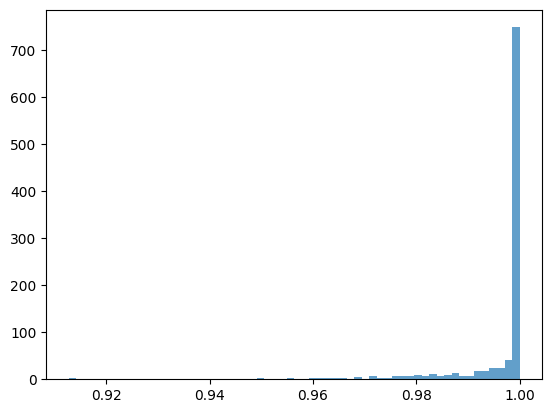

In [18]:
hist = plt.hist(df['ar'], bins=60, alpha=0.7)
print(hist[0][-1], '(',hist[1][-2], hist[1][-1], ')')
plt.show()


Vemos que el 72% de las instancias tienen un ar > 0.999. Por tanto, la distribución está muy concentrada en un extremo. Vamos a hacer en vez de una regresión un clasificador. 

**Binarizar la variable objetivo**

In [19]:
df['etiqueta'] = (df['ar'] <= 0.999).astype(int)
df['etiqueta'].sum()

np.int64(280)

# Añadir nuevas variables de predicción

**Bins del espectro**

In [20]:
n_bins = 1
rows = []
for seed in df['seed'].unique():
    bins = calcular_bins(obtener_espectro(seed), n_bins=n_bins)
    row = bins.set_index('bin')['count'].T  # Series con bin como columnas
    row['seed'] = seed
    rows.append(row)

# Crear el nuevo DataFrame
df_result = pd.DataFrame(rows)

# Hacemos un join_left
df = df.merge(df_result, on='seed', how='left')

df.rename(columns={df.columns[-n_bins + i]: f'int_{i}' for i in range(n_bins)}, inplace=True)

In [21]:
df.head()

,seed,e_gap,e_0,e_1,ar,AR_max,etiqueta,int_0
0,0,0.0710,-1.9603,-1.8893,0.997262,0.999789,1,3
1,3,0.1557,-1.3131,-1.1574,1.000000,1.000000,0,2
2,4,0.2109,-1.7001,-1.4892,0.999993,1.000000,0,1
3,5,0.4416,-1.6183,-1.1767,1.000000,1.000000,0,1
4,6,0.0927,-1.7772,-1.6845,1.000000,1.000000,0,2


**Gaps nuevos**

In [22]:
n_gaps = 4
seed = 0
df_aux = pd.DataFrame(columns=['seed'] + [f'gap_{i}' for i in range(n_gaps)])

for semilla in df.seed.unique():
    espectro = obtener_espectro(semilla, n_nodos=7, atoms_w=4, atoms_l=3)
    e_min = np.min(espectro)
    gaps = espectro - e_min
    gaps.sort()
    gaps = gaps[1:]
    selec_gaps = [gaps[i] for i in range(n_gaps)]

    nueva_instancia = {'seed': semilla} | {f'gap_{i}': float(selec_gaps[i]) for i in range(n_gaps)}
    df_aux = pd.concat([df_aux, pd.DataFrame([nueva_instancia])], ignore_index=True)


df = df.merge(df_aux, on='seed', how='left')
df.drop('e_gap', axis=1, inplace=True)
df.head()

C:\Users\aitoo\AppData\Local\Temp\ipykernel_17660\2411133983.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_aux = pd.concat([df_aux, pd.DataFrame([nueva_instancia])], ignore_index=True)


,seed,e_0,e_1,ar,AR_max,etiqueta,int_0,gap_0,gap_1,gap_2,gap_3
0,0,-1.9603,-1.8893,0.997262,0.999789,1,3,0.0710,0.1720,0.2430,0.3967
1,3,-1.3131,-1.1574,1.000000,1.000000,0,2,0.1557,0.2072,0.2083,0.4155
2,4,-1.7001,-1.4892,0.999993,1.000000,0,1,0.2109,0.2245,0.2702,0.4293
3,5,-1.6183,-1.1767,1.000000,1.000000,0,1,0.4416,0.5507,0.6577,0.7219
4,6,-1.7772,-1.6845,1.000000,1.000000,0,2,0.0927,0.2179,0.3106,0.4188


**HP**

In [23]:
df_hp = pd.read_csv('../res_1000_clasificado.csv')
df_hp = df_hp[['seed', 'curva', 'b', 'hp', 'hp_inv']]
if 'b' not in df.columns:
    df = df.merge(df_hp, on='seed', how='right')

Filtramos por la curva y valor de hp que queramos

In [24]:
df['b'].unique()[12]

np.float64(0.1054308499733486)

In [25]:
df = df[(df['curva'] == 'linear') & (df['b'] == df['b'].unique()[12])]
df.drop(columns=['curva', 'b'], inplace=True)
df.shape

(1000, 13)

# Clasificador

### Clasificador baseline

**Seleccionar variables predictoras**

In [31]:
var_pred = ['gap_0']#, 'e_0', 'hp_inv'] + [f'int_{i}' for i in range(n_bins)]
df_f = df[var_pred + ['etiqueta']]
df_f.head(3)

,gap_0,etiqueta
12,0.0710,1
132,0.1557,0
252,0.2109,0


**Entrenar y evaluar métricas**

In [32]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    precision_recall_fscore_support,
    roc_auc_score
)
from sklearn.preprocessing import StandardScaler


# Variables predictoras y objetivo
X = df_f.drop(columns=['etiqueta'])  # Asegúrate de eliminar 'AR' y la clase
y = df_f['etiqueta']

# Escalado opcional (puede no ser necesario con árboles, pero lo incluyo por si luego usas otros modelos)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Dividir en entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)


Fitting 5 folds for each of 28 candidates, totalling 140 fits
Mejores parámetros: {'class_weight': 'balanced', 'max_depth': 3, 'n_estimators': 150}
Mejor puntuación (f1): 0.6832

Resultados test del mejor modelo obtenido:

Reporte de clasificación:

ROC AUC: 0.8489
F1 Score: 0.6800
              precision    recall  f1-score   support

           0     0.9528    0.7014    0.8080       144
           1     0.5426    0.9107    0.6800        56

    accuracy                         0.7600       200
   macro avg     0.7477    0.8061    0.7440       200
weighted avg     0.8380    0.7600    0.7722       200



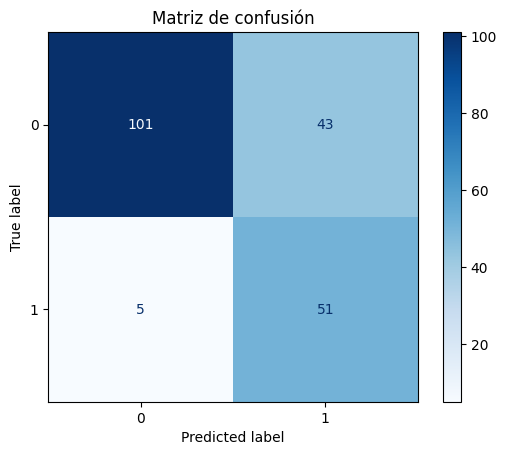

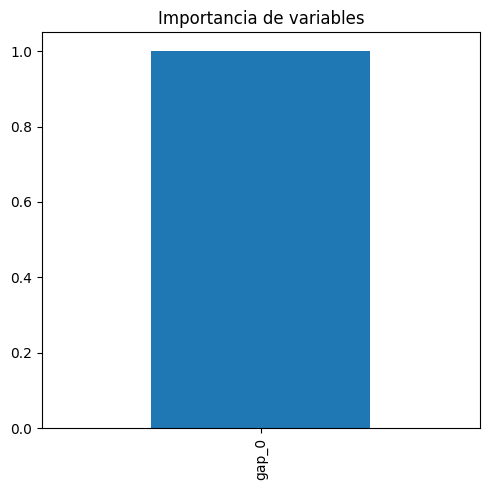

In [33]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

def tune_random_forest(X_train, y_train, X_test, y_test, scoring='f1', cv=5, verbose=1):
    """
    Realiza búsqueda en malla (grid search) de hiperparámetros para RandomForestClassifier.
    
    Parámetros:
        X_train (array-like): Conjunto de entrenamiento (features).
        y_train (array-like): Etiquetas del conjunto de entrenamiento.
        scoring (str): Métrica de evaluación (por defecto: 'f1').
        cv (int): Número de folds para la validación cruzada.
        verbose (int): Nivel de verbosidad para seguimiento.
    
    Retorna:
        best_estimator_ (RandomForestClassifier): Modelo entrenado con los mejores parámetros.
        best_params_ (dict): Diccionario con los mejores hiperparámetros encontrados.
    """
    param_grid = {
        'max_depth': [1, 2, 3, 4, 6, 7, None],
        'n_estimators': [50, 100, 150, 200],#, 250, 300, 500],
        'class_weight': ['balanced']  # Incluye el manejo del desbalance
    }

    rf = RandomForestClassifier(random_state=42)
    
    grid_search = GridSearchCV(
        rf,
        param_grid,
        cv=cv,
        scoring=scoring,
        n_jobs=-1,
        verbose=verbose
    )

    grid_search.fit(X_train, y_train)

    print(f"Mejores parámetros: {grid_search.best_params_}")
    print(f"Mejor puntuación ({scoring}): {grid_search.best_score_:.4f}")
    print("\nResultados test del mejor modelo obtenido:\n")

    grid_search.best_estimator_.fit(X_train, y_train)
    # Predicciones
    y_pred = grid_search.best_estimator_.predict(X_test)
    y_prob = grid_search.best_estimator_.predict_proba(X_test)[:, 1]  # Para ROC AUC

    # Reporte de métricas
    print("Reporte de clasificación:\n")
    auc = roc_auc_score(y_test, y_prob)
    print(f"ROC AUC: {auc:.4f}")
    print(f"F1 Score: {precision_recall_fscore_support(y_test, y_pred, average='binary')[2]:.4f}")
    print(classification_report(y_test, y_pred, digits=4))

    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues")
    plt.title("Matriz de confusión")
    plt.show()

    # Importancia de las características
    importancias = pd.Series(grid_search.best_estimator_.feature_importances_, index=X.columns)
    importancias.sort_values(ascending=False).plot(kind='bar', figsize=(5, 5), title="Importancia de variables")
    plt.tight_layout()
    plt.show()
    
    return grid_search.best_estimator_, grid_search.best_params_
_ = tune_random_forest(X_train, y_train, X_test, y_test, scoring='f1')


### Añadimos nuevas variables

In [34]:
var_pred = ['hp', 'e_0'] + [f'int_{i}' for i in range(n_bins)] + [f'gap_{i}' for i in range(n_gaps)] #['gap_0'] #
df_f = df[var_pred + ['etiqueta']]
df_f.head()

,hp,e_0,int_0,gap_0,gap_1,gap_2,gap_3,etiqueta
12,1.285023,-1.9603,3,0.0710,0.1720,0.2430,0.3967,1
132,1.002408,-1.3131,2,0.1557,0.2072,0.2083,0.4155,0
252,1.000019,-1.7001,1,0.2109,0.2245,0.2702,0.4293,0
372,1.000000,-1.6183,1,0.4416,0.5507,0.6577,0.7219,0
492,1.117259,-1.7772,2,0.0927,0.2179,0.3106,0.4188,0


In [35]:
# Variables predictoras y objetivo
X = df_f.drop(columns=['etiqueta'])  # Asegúrate de eliminar 'AR' y la clase
y = df_f['etiqueta']

# # Escalado opcional (puede no ser necesario con árboles, pero lo incluyo por si luego usas otros modelos)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Dividir en entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

Fitting 5 folds for each of 28 candidates, totalling 140 fits
Mejores parámetros: {'class_weight': 'balanced', 'max_depth': 4, 'n_estimators': 150}
Mejor puntuación (f1): 0.6997

Resultados test del mejor modelo obtenido:

Reporte de clasificación:

ROC AUC: 0.8779
F1 Score: 0.6759
              precision    recall  f1-score   support

           0     0.9369    0.7222    0.8157       144
           1     0.5506    0.8750    0.6759        56

    accuracy                         0.7650       200
   macro avg     0.7437    0.7986    0.7458       200
weighted avg     0.8288    0.7650    0.7765       200



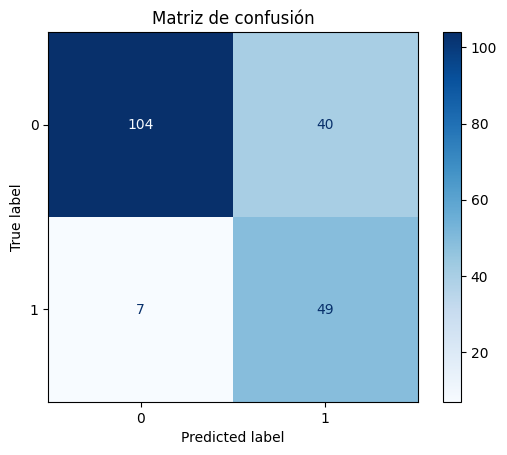

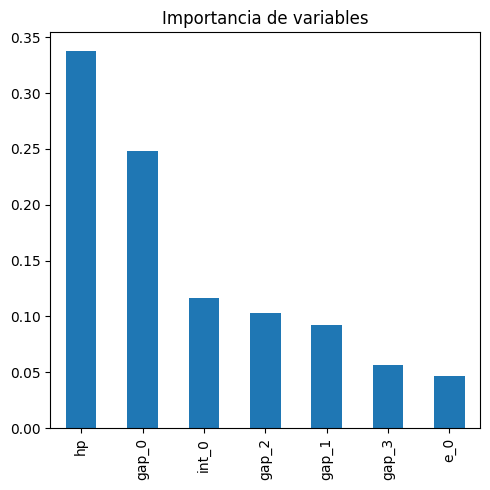

In [36]:
_ = tune_random_forest(X_train, y_train, X_test, y_test, scoring='f1')

#### Búsqueda de HP_inv óptimo.


Hemos visto que estas cuantro variables de arriba son las que mejor modelo hacen. Sin embargo, la variable de HP depende de unos parámetros que hemos especificado como nos ha parecido. Ahora intentaremos ver cuales son los valores óptimos

In [19]:
df = df.drop(columns=['hp', 'hp_inv'])
df = df.merge(df_hp, on='seed', how='right')
df.head()

,seed,e_0,e_1,ar,etiqueta,int_0,gap_0,gap_1,gap_2,gap_3,curva,b,hp,hp_inv
0,0,-1.9603,-1.8893,0.997262,1,3,0.071,0.172,0.243,0.3967,linear,0.001000,1.0,1.0
1,0,-1.9603,-1.8893,0.997262,1,3,0.071,0.172,0.243,0.3967,linear,0.002250,1.0,1.0
2,0,-1.9603,-1.8893,0.997262,1,3,0.071,0.172,0.243,0.3967,linear,0.004257,1.0,1.0
3,0,-1.9603,-1.8893,0.997262,1,3,0.071,0.172,0.243,0.3967,linear,0.007201,1.0,1.0
4,0,-1.9603,-1.8893,0.997262,1,3,0.071,0.172,0.243,0.3967,linear,0.011260,1.0,1.0


In [24]:
len(np.array(df_subset['hp']))

1000

In [25]:
config = []
scores = []

param_grid = {
        'max_depth': [1, 2, 3, 4, 6, 7, None],
        'n_estimators': [50, 100, 150, 200],#, 250, 300, 500],
        'class_weight': ['balanced']  # Incluye el manejo del desbalance
        }   

for b_value in df['b'].unique():
    for curva_value in df['curva'].unique():
        df_subset = df[(df['b'] == b_value) & (df['curva'] == curva_value)]
        # Variables predictoras y objetivo
        X = np.array(df_subset['hp']).reshape(-1, 1) #.drop(columns=['etiqueta', 'ar', 'seed', 'hp', 'curva', 'b'])  # Asegúrate de eliminar 'AR' y la clase
        y = df_subset['etiqueta']

        # # Escalado opcional (puede no ser necesario con árboles, pero lo incluyo por si luego usas otros modelos)
        # scaler = StandardScaler()
        # X_scaled = scaler.fit_transform(X)

        # Dividir en entrenamiento y test
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, stratify=y, random_state=42
        )   

        rf = RandomForestClassifier(random_state=42)
        
        grid_search = GridSearchCV(
            rf,
            param_grid,
            cv=5,
            scoring='f1',
            n_jobs=-1,
            verbose=0
        )

        grid_search.fit(X_train, y_train)
        print('b:', b_value, 'curva:', curva_value, 'f1:', grid_search.best_score_)
        scores.append(grid_search.best_score_)
        config.append((b_value, curva_value))


b: 0.001 curva: linear f1: 0.4357191152322999
b: 0.001 curva: sqrt f1: 0.4374940219990435
b: 0.001 curva: square f1: 0.5564254385964913
b: 0.001 curva: cubic f1: 0.6911956299377182
b: 0.0022498667432039 curva: linear f1: 0.1901803076648695
b: 0.0022498667432039 curva: sqrt f1: 0.4374940219990435
b: 0.0022498667432039 curva: square f1: 0.6707852077001013
b: 0.0022498667432039 curva: cubic f1: 0.6895978842199579
b: 0.0042569601049653 curva: linear f1: 0.1686572291986566
b: 0.0042569601049653 curva: sqrt f1: 0.4374940219990435
b: 0.0042569601049653 curva: square f1: 0.6893999986911874
b: 0.0042569601049653 curva: cubic f1: 0.6827566397381066
b: 0.0072006232317848 curva: linear f1: 0.3091272168691523
b: 0.0072006232317848 curva: sqrt f1: 0.4374940219990435
b: 0.0072006232317848 curva: square f1: 0.6823717388529575
b: 0.0072006232317848 curva: cubic f1: 0.6815292305106972
b: 0.0112601992701627 curva: linear f1: 0.404002743722768
b: 0.0112601992701627 curva: sqrt f1: 0.43682448589191775
b: 0

In [179]:
config[int(np.where(scores == max(scores))[0][0])]

(np.float64(0.1054308499733486), 'linear')

In [27]:
max(scores)

np.float64(0.6989939345916576)

# Añadir propiedades de grafos

In [37]:
# Crear una lista para almacenar las características
graph_data = []

for i in range(len(df)):
    seed = df['seed'].iloc[i]
    n_nodos, atoms_w, atoms_l, scale = 7,4,3, 5e-6
    np.random.seed(seed)
    G, register = Graph_gen(n_nodos, atoms_w, atoms_l, scale)

    # Propiedades globales del grafo
    num_aristas = G.number_of_edges()
    densidad = nx.density(G)
    
    diametro = nx.diameter(G)

    coef_agrupamiento = nx.average_clustering(G)
    grado_medio = np.mean([d for n, d in G.degree()])
    #distribucion_grado = [d for n, d in G.degree()]
    
    excentricidad = np.mean(list(nx.eccentricity(G).values()))
    radio = nx.radius(G)
    
    num_componentes_conectados = nx.number_connected_components(G)

    # Análisis de centralidad
    max_degree_centrality = max(nx.degree_centrality(G).values())
    min_degree_centrality = min(nx.degree_centrality(G).values())
    mean_degree_centrality = np.mean(list(nx.degree_centrality(G).values()))

    max_closeness_centrality = max(nx.closeness_centrality(G).values())
    min_closeness_centrality = min(nx.closeness_centrality(G).values())
    mean_closeness_centrality = np.mean(list(nx.closeness_centrality(G).values()))

    max_centralidad_intermediacion = max(list(nx.betweenness_centrality(G).values()))
    min_centralidad_intermediacion = min(list(nx.betweenness_centrality(G).values()))
    mean_centralidad_intermediacion = np.mean(list(nx.betweenness_centrality(G).values()))

    # Medidas locales
    num_triangulos = sum(nx.triangles(G).values()) // 3  # Cada triángulo se cuenta 3 veces
    num_cliques = len(list(nx.find_cliques(G)))
    
    # Almacenar las características en un diccionario
    graph_data.append({
        'seed': seed,
        'num_aristas': num_aristas,
        'densidad': densidad,
        'diametro': diametro,
        'coef_agrupamiento': coef_agrupamiento,
        'grado_medio': grado_medio,
        #'distribucion_grado': distribucion_grado,
        'excentricidad': excentricidad,
        'radio': radio,
        'num_componentes_conectados': num_componentes_conectados,

        'max_degree_centrality': max_degree_centrality,
        'min_degree_centrality': min_degree_centrality,
        'mean_degree_centrality': mean_degree_centrality,
        'max_closeness_centrality': max_closeness_centrality,
        'min_closeness_centrality': min_closeness_centrality,
        'mean_closeness_centrality': mean_closeness_centrality,
        'max_centralidad_intermediacion': max_centralidad_intermediacion,
        'min_centralidad_intermediacion': min_centralidad_intermediacion,
        'mean_centralidad_intermediacion': mean_centralidad_intermediacion,

        'num_triangulos': num_triangulos,
        'num_cliques': num_cliques
        
    })

# Crear un DataFrame con las características
df_grafos = pd.DataFrame(graph_data)
df_grafos.head()

##################### GUARDAR LOS RESULTADOS EN UN ARCHIVO CSV #####################

,seed,num_aristas,densidad,diametro,coef_agrupamiento,grado_medio,excentricidad,radio,num_componentes_conectados,max_degree_centrality,min_degree_centrality,mean_degree_centrality,max_closeness_centrality,min_closeness_centrality,mean_closeness_centrality,max_centralidad_intermediacion,min_centralidad_intermediacion,mean_centralidad_intermediacion,num_triangulos,num_cliques
0,0,9,0.428571,3,0.452381,2.571429,2.571429,2,1,0.666667,0.166667,0.428571,0.750000,0.461538,0.598618,0.466667,0.0,0.142857,2,5
1,3,11,0.523810,3,0.595238,3.142857,2.571429,2,1,0.833333,0.166667,0.523810,0.857143,0.428571,0.644929,0.333333,0.0,0.123810,6,4
2,4,8,0.380952,4,0.571429,2.285714,3.285714,2,1,0.500000,0.166667,0.380952,0.666667,0.375000,0.506323,0.600000,0.0,0.209524,2,4
3,5,11,0.523810,3,0.485714,3.142857,2.428571,2,1,0.833333,0.333333,0.523810,0.857143,0.500000,0.653401,0.388889,0.0,0.114286,5,5
4,6,10,0.476190,3,0.780952,2.857143,2.428571,2,1,0.833333,0.333333,0.476190,0.857143,0.500000,0.637817,0.566667,0.0,0.123810,4,4


In [38]:
df_grafos2 = df.merge(df_grafos, on='seed', how='left')
df_grafos2.head()

,seed,e_0,e_1,ar,AR_max,etiqueta,int_0,gap_0,gap_1,gap_2,...,min_degree_centrality,mean_degree_centrality,max_closeness_centrality,min_closeness_centrality,mean_closeness_centrality,max_centralidad_intermediacion,min_centralidad_intermediacion,mean_centralidad_intermediacion,num_triangulos,num_cliques
0,0,-1.9603,-1.8893,0.997262,0.999789,1,3,0.0710,0.1720,0.2430,...,0.166667,0.428571,0.750000,0.461538,0.598618,0.466667,0.0,0.142857,2,5
1,3,-1.3131,-1.1574,1.000000,1.000000,0,2,0.1557,0.2072,0.2083,...,0.166667,0.523810,0.857143,0.428571,0.644929,0.333333,0.0,0.123810,6,4
2,4,-1.7001,-1.4892,0.999993,1.000000,0,1,0.2109,0.2245,0.2702,...,0.166667,0.380952,0.666667,0.375000,0.506323,0.600000,0.0,0.209524,2,4
3,5,-1.6183,-1.1767,1.000000,1.000000,0,1,0.4416,0.5507,0.6577,...,0.333333,0.523810,0.857143,0.500000,0.653401,0.388889,0.0,0.114286,5,5
4,6,-1.7772,-1.6845,1.000000,1.000000,0,2,0.0927,0.2179,0.3106,...,0.333333,0.476190,0.857143,0.500000,0.637817,0.566667,0.0,0.123810,4,4


In [39]:
cor_mat = df_grafos2.drop(columns=['seed'], inplace=True)

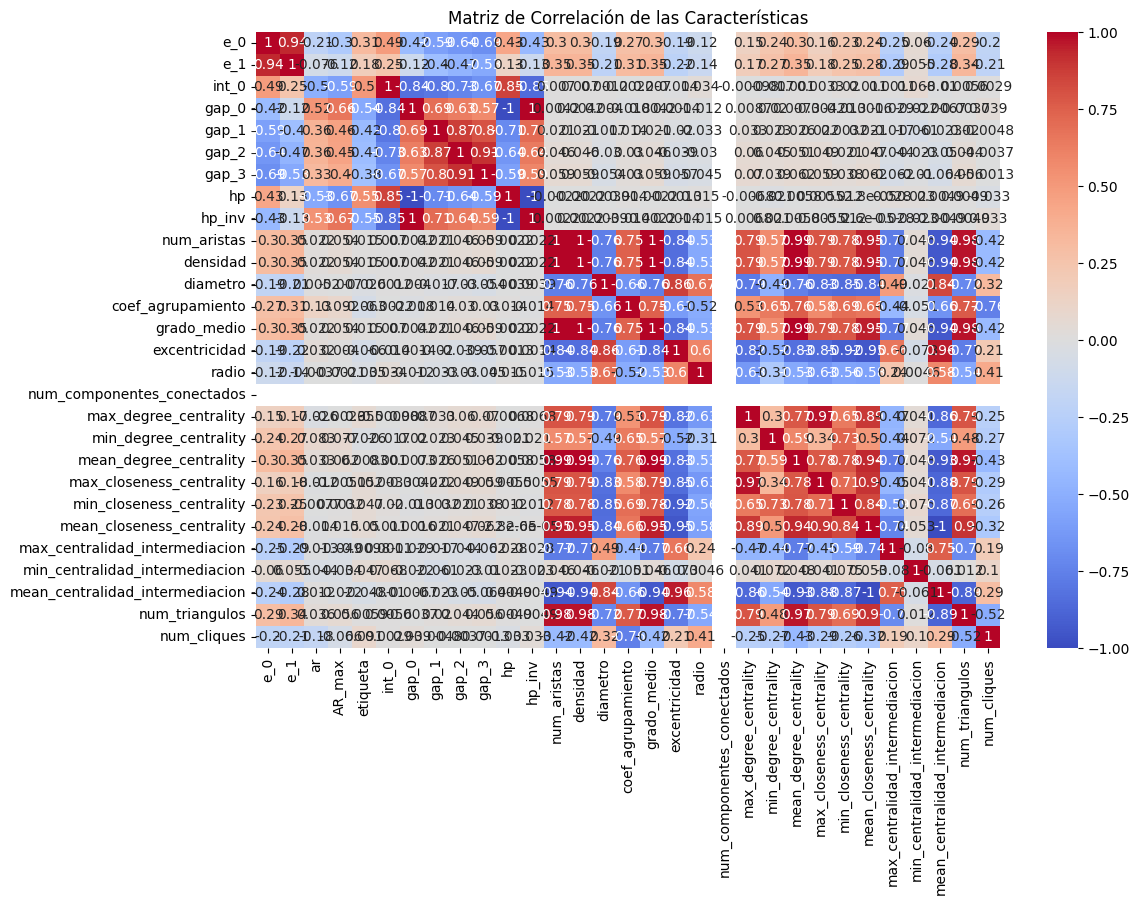

In [40]:
correlation_matrix = df_grafos2.corr(method='spearman')

# Visualización
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix.drop(['ar', 'AR_max', 'etiqueta']), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Matriz de Correlación de las Características")
plt.show()

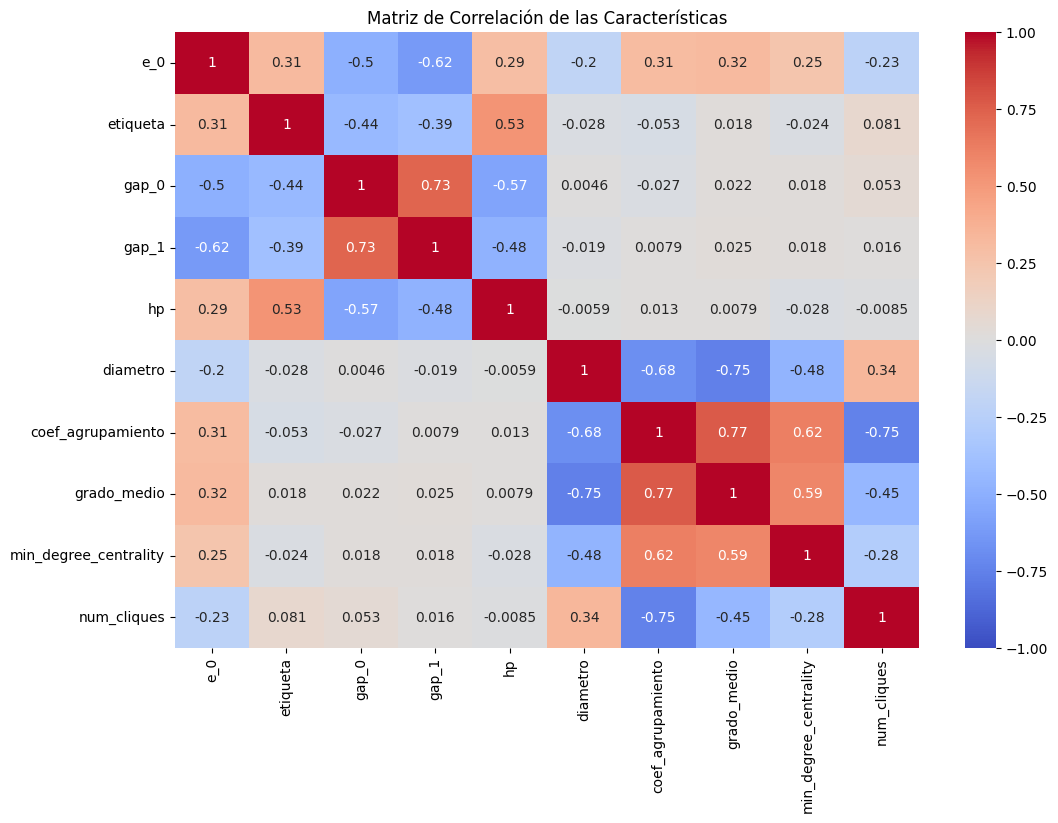

In [41]:
df_post_corr = df_grafos2.drop(columns=['num_aristas', 'densidad', 'mean_degree_centrality',
                       'num_triangulos', 'min_centralidad_intermediacion', 'excentricidad', 'radio',
                       'mean_centralidad_intermediacion', 'max_centralidad_intermediacion', 'max_degree_centrality', 'max_closeness_centrality', 
                       'mean_closeness_centrality', 'max_closeness_centrality', 'min_closeness_centrality',
                       'num_componentes_conectados', 'ar', 'hp_inv', 'e_1', 'int_0', 'gap_2', 'gap_3', 'AR_max'])

correlation_matrix = df_post_corr.corr()

# Visualización
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Matriz de Correlación de las Características")
plt.show()

In [42]:
X = df_post_corr.drop(columns=['etiqueta'])  # Asegúrate de eliminar 'AR' y la clase
y = df_post_corr['etiqueta']

In [43]:
# Escalado opcional (puede no ser necesario con árboles, pero lo incluyo por si luego usas otros modelos)
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# Al utilizar un RF no hace falta normalizar los conjuntos de datos

# Dividir en entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

Fitting 5 folds for each of 28 candidates, totalling 140 fits
Mejores parámetros: {'class_weight': 'balanced', 'max_depth': 3, 'n_estimators': 200}
Mejor puntuación (f1): 0.7034

Resultados test del mejor modelo obtenido:

Reporte de clasificación:

ROC AUC: 0.8796
F1 Score: 0.6993
              precision    recall  f1-score   support

           0     0.9469    0.7431    0.8327       144
           1     0.5747    0.8929    0.6993        56

    accuracy                         0.7850       200
   macro avg     0.7608    0.8180    0.7660       200
weighted avg     0.8427    0.7850    0.7953       200



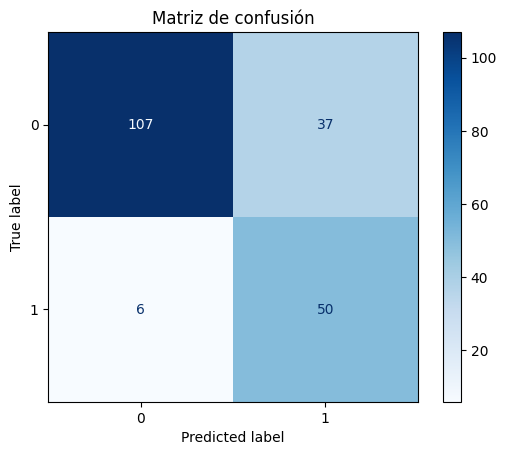

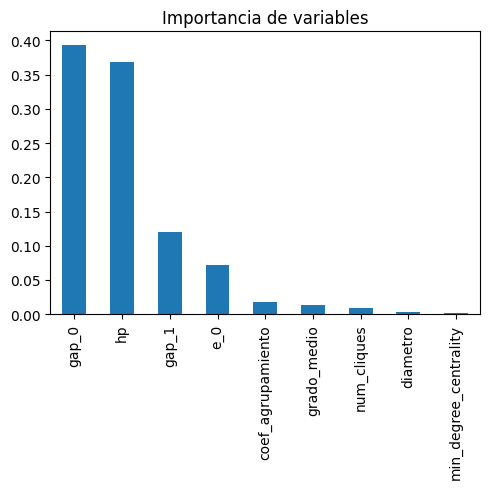

In [44]:
best_estimator, best_params = tune_random_forest(X_train, y_train, X_test, y_test, scoring='f1') #roc_auc

# Solo variables de grafo

In [292]:
X = df_post_corr.drop(columns=['etiqueta'])  # Asegúrate de eliminar 'AR' y la clase
y = df_post_corr['etiqueta']
X = X.drop(columns=['e_gap', 'e_0', 'e_1', 'int_0', 'hp'])

In [293]:
# Dividir en entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

Fitting 5 folds for each of 28 candidates, totalling 140 fits
Mejores parámetros: {'class_weight': 'balanced', 'max_depth': 2, 'n_estimators': 100}
Mejor puntuación (roc_auc): 0.5560

Resultados test del mejor modelo obtenido:

Reporte de clasificación:

ROC AUC: 0.5185
F1 Score: 0.3286
              precision    recall  f1-score   support

           0     0.7155    0.5764    0.6385       144
           1     0.2738    0.4107    0.3286        56

    accuracy                         0.5300       200
   macro avg     0.4947    0.4936    0.4835       200
weighted avg     0.5918    0.5300    0.5517       200



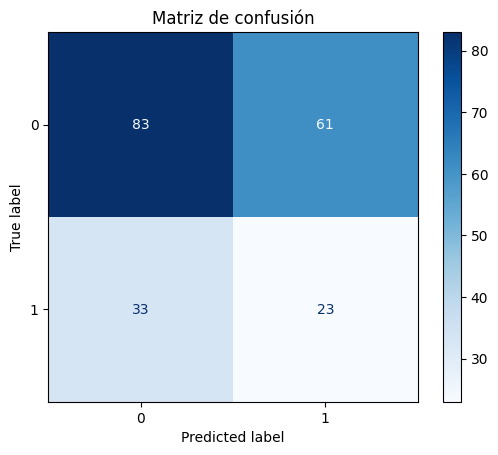

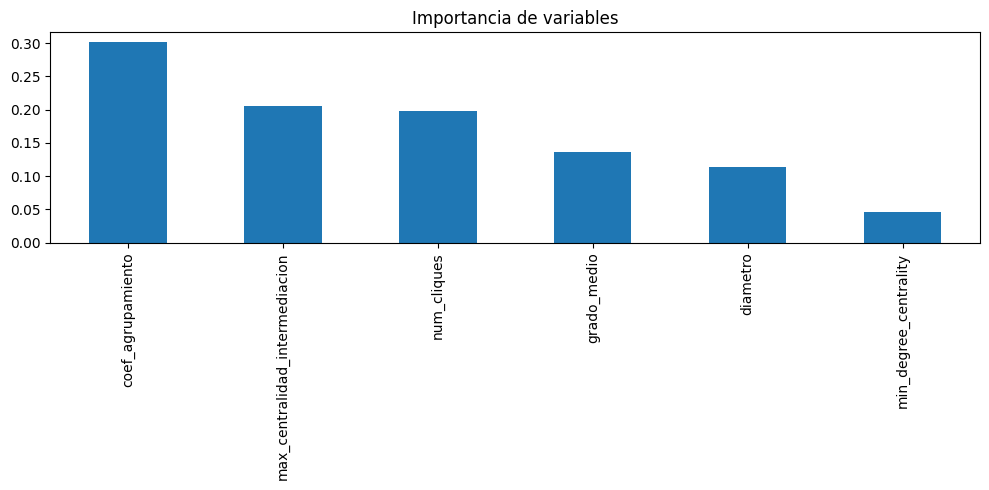

In [295]:
best_estimator, best_params = tune_random_forest(X_train, y_train, X_test, y_test, scoring='roc_auc') #roc_auc